In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [110]:
from collections import Counter

import tensorflow as tf
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt

In [97]:
# Load IMDB data
imdb = tf.keras.datasets.imdb.load_data(
    path='imdb.npz', num_words=None, skip_top=0, maxlen=None, seed=113,
    start_char=1, oov_char=2, index_from=3
)

In [4]:
# Load IMDB word index
word_idx = tf.keras.datasets.imdb.get_word_index(
    path='imdb_word_index.json'
)

1646592/1641221 [==============================] - 0s 0us/step


In [5]:
word_dict = {v: k for k, v in word_idx.items()}

def get_sentence(arr):
    return ' '.join(word_dict[i] for i in arr)

In [98]:
# Extract train and test data
X_train, y_train = imdb[0][0], imdb[0][1]
X_test, y_test = imdb[1][0], imdb[1][1]

print((y_train == 1).sum(), 'positive reviews')
print((y_train == 0).sum(), 'negative reviews')

12500 positive reviews
12500 negative reviews


In [7]:
arr = np.random.choice(X_train, 1)[0]
get_sentence(arr)

"the undermined way wants in is very star guilty br while fact leopard this of build to as or admit fact crossword room illiteracy it by br were where learned more he attention obviously an dean not seen maher but of pure to pig but please hallucination thinking movie fight depth assassinate first d i i this maher besides rent effects so diminish hunky david nobody chance suzanne inmate friend unneeded br be tested to su 77 her would lul is flashing linda film really would authors about perpetrated but be butler inmate it is version gone br circuit based to childhood by br of suspense flick boring this is fact you he's intense urmila this of accordingly as logical it viewer film him drops to of amazing marquis norma better goes it is writer br snotty fact i i pig br please it has is fact fades suburbs constraints like it cushion who by br be right spoiling of mark tho as face it tribute but make ocean to electric subtitles tho action it's action his at now her going viewing apologise t

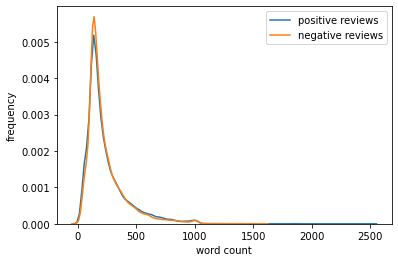

In [8]:
# Find the most frequent review lengths
len_pos = list(map(len, X_train[y_train == 1]))
len_neg = list(map(len, X_train[y_train == 0]))

# Plot histograms for review lenghts
sns.kdeplot(len_pos, label='positive reviews')
ax = sns.kdeplot(len_neg, label='negative reviews')
_ = ax.set(xlabel='word count', ylabel='frequency')

In [57]:
print('Most frerquent length of positive reviews: {} words ({} reviews)'.format(*Counter(len_pos).most_common(1)[0]))
print('Most frerquent length of negative reviews: {} words ({} reviews)'.format(*Counter(len_neg).most_common(1)[0]))

Most frerquent length of positive reviews: 125 words (95 reviews)
Most frerquent length of negative reviews: 132 words (105 reviews)


In [44]:
# Get index of positive and negative reviews
idx_pos = np.where(y_train == 1)[0]
idx_neg = np.where(y_train == 0)[0]
idx_pos

array([    0,     3,     6, ..., 24994, 24995, 24998])

In [99]:
# Add special tokens to handle exceptions
max_id = max(word_dict)
start_id = max_id + 1
pad_id = max_id + 2
word_idx['<START>'] = start_id
word_idx['<PAD>'] = pad_id

for arr in [X_train, X_test]:
    for idx in range(arr.shape[0]):
        arr[idx] = [start_id] + arr[idx][:255] + [pad_id] * (255 - len(arr[idx]))
        
X_train = np.vstack(X_train)
X_test = np.vstack(X_test)

In [101]:
# Select a fraction of positive review data
pos_idx_frac = np.random.choice(idx_pos, int(idx_pos.shape[0] / 2))

# Replicate positive reviews
repl_idx = np.concatenate([np.tile(pos_idx_frac, 2), idx_neg])
X_train_repl = X_train[repl_idx]
y_train_repl = y_train[repl_idx]
X_train_repl.shape

(25000, 256)

In [14]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

In [73]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(word_idx) + 1, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [74]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [76]:
history = model.fit(x=X_train_repl, y=y_train_repl, epochs=10,
                    validation_data=(X_test, y_test), 
                    validation_steps=30)

Epoch 1/10
782/782 [==============================] - 58s 74ms/step - loss: 0.2445 - accuracy: 0.9059 - val_loss: 0.3832 - val_accuracy: 0.8277
Epoch 2/10
782/782 [==============================] - 56s 71ms/step - loss: 0.1032 - accuracy: 0.9676 - val_loss: 0.6090 - val_accuracy: 0.7975
Epoch 3/10
782/782 [==============================] - 56s 72ms/step - loss: 0.0471 - accuracy: 0.9865 - val_loss: 0.6152 - val_accuracy: 0.7874
Epoch 4/10
782/782 [==============================] - 56s 72ms/step - loss: 0.0218 - accuracy: 0.9948 - val_loss: 0.8568 - val_accuracy: 0.7880
Epoch 5/10
782/782 [==============================] - 56s 71ms/step - loss: 0.0130 - accuracy: 0.9964 - val_loss: 0.8113 - val_accuracy: 0.8053
Epoch 6/10
782/782 [==============================] - 55s 71ms/step - loss: 0.0061 - accuracy: 0.9984 - val_loss: 0.8053 - val_accuracy: 0.8061
Epoch 7/10
782/782 [==============================] - 56s 72ms/step - loss: 0.0068 - accuracy: 0.9980 - val_loss: 1.4403 - val_accuracy:

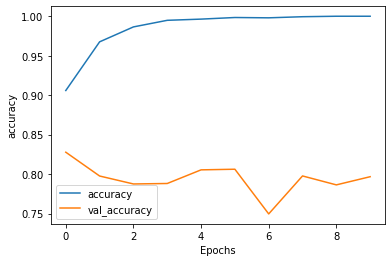

In [90]:
plot_graphs(history, 'accuracy')

In [103]:
preds = model.predict(X_test)

In [104]:
preds = (preds >= .5).astype(int)

In [109]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.74      0.92      0.82     12500
           1       0.89      0.67      0.77     12500

    accuracy                           0.80     25000
   macro avg       0.82      0.80      0.79     25000
weighted avg       0.82      0.80      0.79     25000



In [111]:
print(confusion_matrix(y_test, preds))

SyntaxError: unexpected EOF while parsing (<ipython-input-111-8a22e9ce4f5f>, line 1)